# Importing Libraries

In [ ]:
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython import display
from tensorflow import keras
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import *
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from keras.preprocessing import image
from tensorflow.keras import Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

np.random.seed(42)
tf.random.set_seed(42)

## Loading Data

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection --unzip
! kaggle datasets download -d ahmedhamada0/brain-tumor-detection --unzip

 89% 75.0M/84.0M [00:00<00:00, 112MB/s] 
100% 84.0M/84.0M [00:00<00:00, 98.3MB/s]


In [ ]:
height, width, channel  = 224, 224, 3
batch_size=1
data_dir = '/content/Brain tumor data'

## Helping Functions

In [ ]:
def image_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.2,
            )
    train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=batch_size,
            subset="training",
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    val_ds = datagen.flow_from_directory(
              data_dir,
              subset="validation",
              class_mode='binary',
              target_size=(height, width),
              batch_size=batch_size,
            classes={'no': 0., 'yes': 1.}
            )
    return train_ds, val_ds

def augmentataion_generator(height,width):
  datagen = ImageDataGenerator(
          rescale=1./255.,
          width_shift_range=0.1,
          height_shift_range=0.1,
          shear_range=0.1,
          zoom_range=0.1,
          rotation_range=30,
          horizontal_flip=True,
          brightness_range=(0.5, 1.0)
          )
  aug_train_ds = datagen.flow_from_directory(
          data_dir,
          shuffle=True,
          class_mode='binary',
          target_size=(height, width),
          classes={'no': 0., 'yes': 1.}
          )
  return aug_train_ds


def earlystop(patience = 5):
  return [tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max",restore_best_weights=True, patience= patience)]


In [ ]:
def model_evaluation(model,train_data):
  train_result = model.evaluate(train_data,verbose = False)
  val_result = model.evaluate(val_ds,verbose = False)

  df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])

  ypred = model.predict(val_ds[0][0], verbose = False)
  ypred = np.array([1 if x > 0.5 else 0 for x in ypred])
  ytest = val_ds[0][-1]

  print('----------------------------------')
  print('----------------------------------')
  print(df)
  print('----------------------------------')
  print('----------------------------------')
  print('Auc_roc Score :\n', roc_auc_score(ytest,ypred))
  print('----------------------------------')
  print('----------------------------------')
  print('Confusion_Matrix:\n',confusion_matrix(ytest, ypred))
  print('----------------------------------')
  print('----------------------------------')
  print('\nClassification_report:\n',classification_report(ypred,ytest))
  print('----------------------------------')
  print('----------------------------------')

In [ ]:

def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots

    # Plot accuracy curve
    axs[0].plot(epochs, acc, label='training acc')
    axs[0].plot(epochs, val_acc, label='validation acc')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy-%')
    axs[0].legend()

    # Plot loss curve
    axs[1].plot(epochs, loss, label='training loss')
    axs[1].plot(epochs, val_loss, label='validation loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.tight_layout()  # Adjust the spacing between subplots
    plt.show()

In [ ]:
train_ds, val_ds = image_generator(height,width)
aug_train_ds = augmentataion_generator(height,width)
total_image = np.concatenate([train_ds.labels,val_ds.labels])
print('\n\n',{'No_brain_tumor_cases':len(np.where(total_image==0)[0]),
      'brain_tumor_cases':len(np.where(total_image==1)[0])})


## How Data Looks

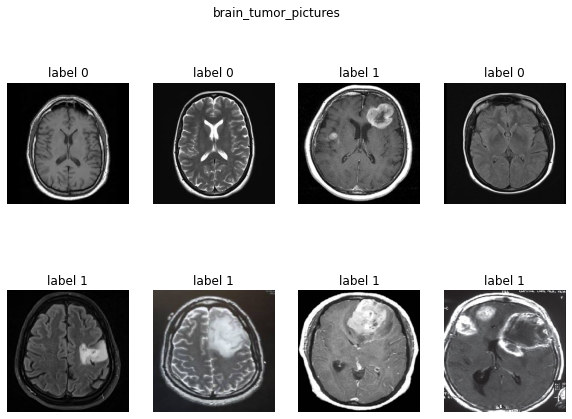

In [ ]:
  fig, ax = plt.subplots(2, 4, figsize=(10, 7))
fig.suptitle("brain_tumor_pictures")
for k in range(8):
    images, labels = train_ds.next()
    i, j = k//4, k%4
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f'label {int(labels[0])}')
    ax[i, j].axis('off')
plt.show()

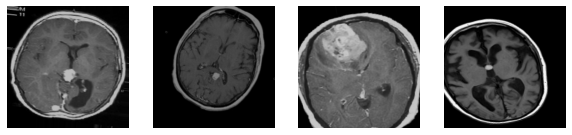

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10,10))

for i in range(4):
  image = next(train_ds)[0]
  image = np.squeeze(image)
  ax[i].imshow(image)
  ax[i].axis('off')

## VGG19

In [ ]:
tf.keras.backend.clear_session()
input_shape = (height, width, channel)

base_model = tf.keras.applications.vgg19.VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape)

base_model.trainable = False

model_vgg19 = tf.keras.Sequential()
model_vgg19.add(base_model)
model_vgg19.add(tf.keras.layers.Flatten())

model_vgg19.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_vgg19.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['accuracy'])
model_vgg19.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
vgg19_history = model_vgg19.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        shuffle=True,
        verbose=True)

Epoch 1/20
4/4 [==============================] - 2s 425ms/step - loss: 0.7795 - accuracy: 0.8867 - val_loss: 1.4364 - val_accuracy: 0.7600
Epoch 2/20
4/4 [==============================] - 2s 464ms/step - loss: 0.5320 - accuracy: 0.9163 - val_loss: 1.5035 - val_accuracy: 0.7800
Epoch 3/20
4/4 [==============================] - 2s 470ms/step - loss: 0.5107 - accuracy: 0.9212 - val_loss: 1.4733 - val_accuracy: 0.8000
Epoch 4/20
4/4 [==============================] - 2s 570ms/step - loss: 0.3906 - accuracy: 0.9261 - val_loss: 1.0056 - val_accuracy: 0.8000
Epoch 5/20
4/4 [==============================] - 2s 575ms/step - loss: 0.1294 - accuracy: 0.9606 - val_loss: 0.6326 - val_accuracy: 0.8600
Epoch 6/20
4/4 [==============================] - 2s 434ms/step - loss: 0.1863 - accuracy: 0.9458 - val_loss: 0.6271 - val_accuracy: 0.8800
Epoch 7/20
4/4 [==============================] - 2s 468ms/step - loss: 0.0886 - accuracy: 0.9704 - val_loss: 0.4778 - val_accuracy: 0.8800
Epoch 8/20
4/4 [====

In [ ]:
model_evaluation(model_vgg19,train_ds)

----------------------------------
----------------------------------
        Train       Val
Loss  0.00141  0.386784
Acc   1.00000  0.900000
----------------------------------
----------------------------------
Auc_roc Score :
 0.8887945670628183
----------------------------------
----------------------------------
Confusion_Matrix:
 [[16  3]
 [ 2 29]]
----------------------------------
----------------------------------

Classification_report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86        18
           1       0.94      0.91      0.92        32

    accuracy                           0.90        50
   macro avg       0.89      0.90      0.89        50
weighted avg       0.90      0.90      0.90        50

----------------------------------
----------------------------------


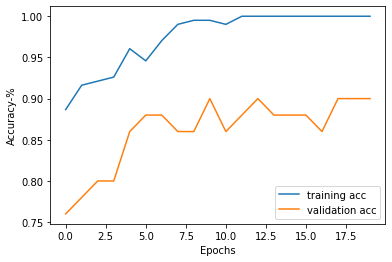

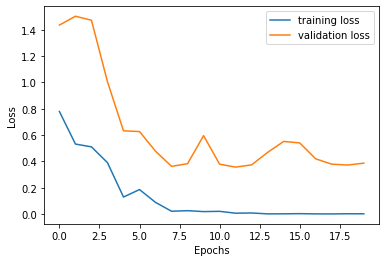

In [ ]:
plot_learning_curve(vgg19_history)

## Adding Image Augmentation

In [ ]:
vgg19_a_history = model_vgg19.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=20,
        verbose=True)

Epoch 1/20
8/8 [==============================] - 5s 566ms/step - loss: 0.5440 - accuracy: 0.8419 - val_loss: 0.3681 - val_accuracy: 0.8800
Epoch 2/20
8/8 [==============================] - 4s 541ms/step - loss: 0.4986 - accuracy: 0.8379 - val_loss: 0.3493 - val_accuracy: 0.9400
Epoch 3/20
8/8 [==============================] - 4s 535ms/step - loss: 0.6207 - accuracy: 0.8063 - val_loss: 0.1904 - val_accuracy: 0.9000
Epoch 4/20
8/8 [==============================] - 4s 543ms/step - loss: 0.5076 - accuracy: 0.8735 - val_loss: 0.1259 - val_accuracy: 0.9400
Epoch 5/20
8/8 [==============================] - 4s 537ms/step - loss: 0.5188 - accuracy: 0.8617 - val_loss: 0.0720 - val_accuracy: 0.9600
Epoch 6/20
8/8 [==============================] - 4s 548ms/step - loss: 0.5518 - accuracy: 0.8419 - val_loss: 0.1630 - val_accuracy: 0.9600
Epoch 7/20
8/8 [==============================] - 4s 558ms/step - loss: 0.4103 - accuracy: 0.8656 - val_loss: 0.6616 - val_accuracy: 0.8400
Epoch 8/20
8/8 [====

In [ ]:
model_evaluation(model_vgg19,aug_train_ds)

----------------------------------
----------------------------------
         Train      Val
Loss  0.434383  0.03434
Acc   0.869565  0.98000
----------------------------------
----------------------------------
Auc_roc Score :
 0.9838709677419355
----------------------------------
----------------------------------
Confusion_Matrix:
 [[19  0]
 [ 1 30]]
----------------------------------
----------------------------------

Classification_report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.97      1.00      0.98        30

    accuracy                           0.98        50
   macro avg       0.98      0.97      0.98        50
weighted avg       0.98      0.98      0.98        50

----------------------------------
----------------------------------


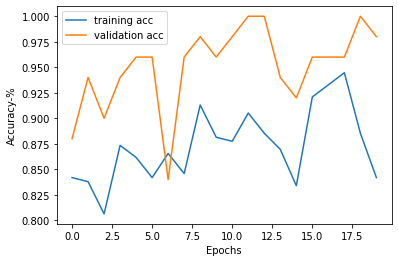

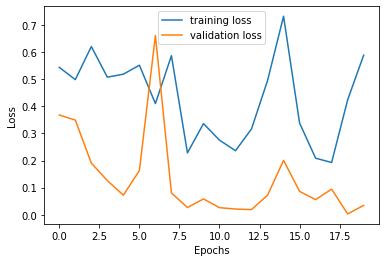

In [ ]:
plot_learning_curve(vgg19_a_history)

## InceptionV3

In [ ]:
tf.keras.backend.clear_session()
input_shape = (height, width, channel)
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_inceptionv3 = tf.keras.Sequential()
model_inceptionv3.add(base_model)
model_inceptionv3.add(tf.keras.layers.Flatten())
model_inceptionv3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_inceptionv3.compile(
                    loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=['accuracy']
)
model_inceptionv3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 1)                 51201     
                                                                 
Total params: 21,853,985
Trainable params: 51,201
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
inceptionv3_history = model_inceptionv3.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        verbose=True)

Epoch 1/20
4/4 [==============================] - 64s 20s/step - loss: 2.7724 - accuracy: 0.6305 - val_loss: 6.0262 - val_accuracy: 0.3800
Epoch 2/20
4/4 [==============================] - 1s 269ms/step - loss: 3.4591 - accuracy: 0.5419 - val_loss: 4.5517 - val_accuracy: 0.6200
Epoch 3/20
4/4 [==============================] - 1s 262ms/step - loss: 2.4413 - accuracy: 0.6798 - val_loss: 0.5413 - val_accuracy: 0.8000
Epoch 4/20
4/4 [==============================] - 1s 273ms/step - loss: 0.7793 - accuracy: 0.8276 - val_loss: 0.9010 - val_accuracy: 0.8000
Epoch 5/20
4/4 [==============================] - 1s 342ms/step - loss: 0.2662 - accuracy: 0.9261 - val_loss: 1.2941 - val_accuracy: 0.8000
Epoch 6/20
4/4 [==============================] - 1s 250ms/step - loss: 0.5657 - accuracy: 0.8719 - val_loss: 0.8833 - val_accuracy: 0.8400
Epoch 7/20
4/4 [==============================] - 1s 265ms/step - loss: 0.2365 - accuracy: 0.9458 - val_loss: 0.5662 - val_accuracy: 0.8800
Epoch 8/20
4/4 [=====

In [ ]:
model_evaluation(model_inceptionv3,train_ds)

----------------------------------
----------------------------------
         Train       Val
Loss  0.000955  0.402124
Acc   1.000000  0.920000
----------------------------------
----------------------------------
Auc_roc Score :
 0.9049235993208828
----------------------------------
----------------------------------
Confusion_Matrix:
 [[16  3]
 [ 1 30]]
----------------------------------
----------------------------------

Classification_report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89        17
           1       0.97      0.91      0.94        33

    accuracy                           0.92        50
   macro avg       0.90      0.93      0.91        50
weighted avg       0.93      0.92      0.92        50

----------------------------------
----------------------------------


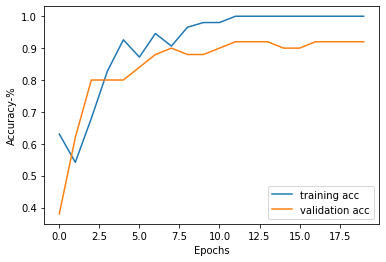

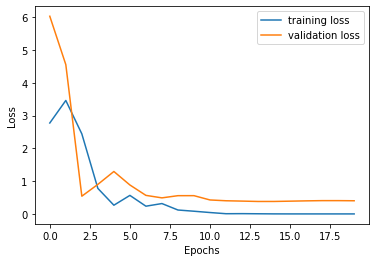

In [ ]:
plot_learning_curve(inceptionv3_history)

## Adding Image Augmentation

In [ ]:
aug_train_ds = augmentataion_generator(height,width)

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3,
                              patience=3, min_lr=0.0000001)
callbacks_list = [early,reduce_lr]


inceptionv3_a_history = model_inceptionv3.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=25,
        verbose=True,
        callbacks=callbacks_list)

Found 253 images belonging to 2 classes.
Epoch 1/25
8/8 [==============================] - 4s 502ms/step - loss: 0.1237 - accuracy: 0.9565 - val_loss: 0.0536 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 2/25
8/8 [==============================] - 4s 485ms/step - loss: 0.1191 - accuracy: 0.9447 - val_loss: 0.0817 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 3/25
8/8 [==============================] - 4s 484ms/step - loss: 0.2011 - accuracy: 0.9407 - val_loss: 0.9074 - val_accuracy: 0.7400 - lr: 0.0010
Epoch 4/25
8/8 [==============================] - 4s 500ms/step - loss: 0.3811 - accuracy: 0.8933 - val_loss: 0.0196 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/25
8/8 [==============================] - 5s 588ms/step - loss: 0.0688 - accuracy: 0.9684 - val_loss: 0.1689 - val_accuracy: 0.9400 - lr: 3.0000e-04
Epoch 6/25
8/8 [==============================] - 4s 492ms/step - loss: 0.0933 - accuracy: 0.9763 - val_loss: 0.0191 - val_accuracy: 1.0000 - lr: 3.0000e-04
Epoch 7/25
8/8 [=================

In [ ]:
model_evaluation(model_inceptionv3,aug_train_ds)

----------------------------------
----------------------------------
         Train       Val
Loss  0.105077  0.019101
Acc   0.972332  1.000000
----------------------------------
----------------------------------
Auc_roc Score :
 1.0
----------------------------------
----------------------------------
Confusion_Matrix:
 [[19  0]
 [ 0 31]]
----------------------------------
----------------------------------

Classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        31

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

----------------------------------
----------------------------------


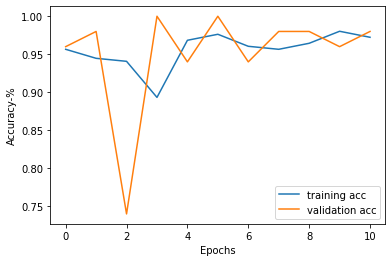

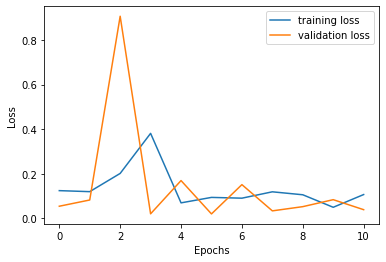

In [ ]:
plot_learning_curve(inceptionv3_a_history)

## MobileNetV2

In [ ]:
mobilenet = MobileNetV2(input_shape=(height,width,channel),weights = "imagenet", include_top = False)

for layer in mobilenet.layers:
    layer.trainable = False

model_mobilenet = Sequential()
model_mobilenet.add(mobilenet)
model_mobilenet.add(Flatten())
model_mobilenet.add(Dense(1,activation='sigmoid'))
model_mobilenet.summary()

model_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 62721     
                                                                 
Total params: 2,320,705
Trainable params: 62,721
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
mobilenet_history = model_mobilenet.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        verbose=True)

Epoch 1/20
4/4 [==============================] - 4s 487ms/step - loss: 3.1375 - accuracy: 0.5468 - val_loss: 1.4503 - val_accuracy: 0.6400
Epoch 2/20
4/4 [==============================] - 1s 305ms/step - loss: 2.5439 - accuracy: 0.5419 - val_loss: 0.5166 - val_accuracy: 0.8200
Epoch 3/20
4/4 [==============================] - 1s 209ms/step - loss: 0.8806 - accuracy: 0.8325 - val_loss: 2.0706 - val_accuracy: 0.7400
Epoch 4/20
4/4 [==============================] - 1s 219ms/step - loss: 0.6293 - accuracy: 0.8867 - val_loss: 0.6192 - val_accuracy: 0.8600
Epoch 5/20
4/4 [==============================] - 1s 240ms/step - loss: 0.3419 - accuracy: 0.9163 - val_loss: 0.7132 - val_accuracy: 0.8800
Epoch 6/20
4/4 [==============================] - 1s 213ms/step - loss: 0.1102 - accuracy: 0.9606 - val_loss: 0.4149 - val_accuracy: 0.9400
Epoch 7/20
4/4 [==============================] - 1s 227ms/step - loss: 0.0480 - accuracy: 0.9754 - val_loss: 0.5686 - val_accuracy: 0.8600
Epoch 8/20
4/4 [====

In [ ]:
model_evaluation(model_mobilenet,train_ds)

----------------------------------
----------------------------------
         Train      Val
Loss  0.000193  0.33433
Acc   1.000000  0.94000
----------------------------------
----------------------------------
Auc_roc Score :
 0.9414261460101868
----------------------------------
----------------------------------
Confusion_Matrix:
 [[18  1]
 [ 2 29]]
----------------------------------
----------------------------------

Classification_report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.94      0.97      0.95        30

    accuracy                           0.94        50
   macro avg       0.94      0.93      0.94        50
weighted avg       0.94      0.94      0.94        50

----------------------------------
----------------------------------


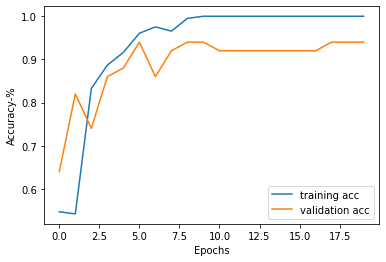

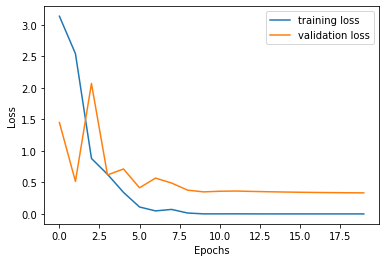

In [ ]:
plot_learning_curve(mobilenet_history)

## Adding Image augmentation...

In [ ]:
mobilenet_a_history = model_mobilenet.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=1,
        verbose=True,)

8/8 [==============================] - 4s 486ms/step - loss: 0.0424 - accuracy: 0.9723 - val_loss: 0.0093 - val_accuracy: 1.0000


In [ ]:
model_evaluation(model_mobilenet,aug_train_ds)

----------------------------------
----------------------------------
         Train       Val
Loss  0.032073  0.009284
Acc   0.984190  1.000000
----------------------------------
----------------------------------
Auc_roc Score :
 1.0
----------------------------------
----------------------------------
Confusion_Matrix:
 [[19  0]
 [ 0 31]]
----------------------------------
----------------------------------

Classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        31

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

----------------------------------
----------------------------------


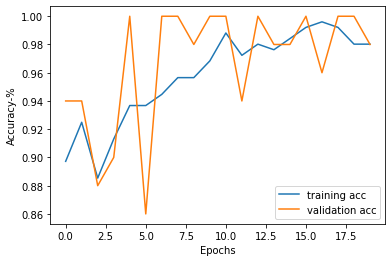

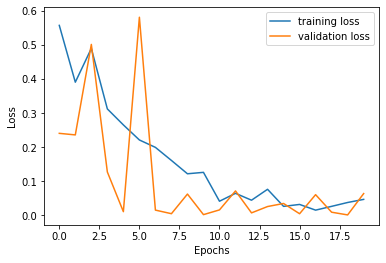

In [ ]:
plot_learning_curve(mobilenet_a_history)

## ResNet50

In [ ]:
resnet = ResNet50(include_top=False,
                  weights='imagenet',
                  input_shape=(height,width,channel))

for layer in resnet.layers:
    layer.trainable = False


resnet_model = Sequential()
resnet_model.add(resnet)
resnet_model.add(Flatten())
resnet_model.add(Dense(1,activation='sigmoid'))
resnet_model.summary()

resnet_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics = ['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 1)                 100353    
                                                                 
Total params: 23,688,065
Trainable params: 100,353
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
resnet_history = resnet_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        verbose=True)

Epoch 1/20
4/4 [==============================] - 5s 638ms/step - loss: 1.7112 - accuracy: 0.5813 - val_loss: 1.9762 - val_accuracy: 0.3800
Epoch 2/20
4/4 [==============================] - 1s 371ms/step - loss: 1.7075 - accuracy: 0.4877 - val_loss: 1.5988 - val_accuracy: 0.6200
Epoch 3/20
4/4 [==============================] - 1s 426ms/step - loss: 1.5809 - accuracy: 0.6256 - val_loss: 0.6867 - val_accuracy: 0.6600
Epoch 4/20
4/4 [==============================] - 1s 462ms/step - loss: 0.9364 - accuracy: 0.6256 - val_loss: 0.8861 - val_accuracy: 0.6400
Epoch 5/20
4/4 [==============================] - 1s 281ms/step - loss: 0.6273 - accuracy: 0.6995 - val_loss: 1.1793 - val_accuracy: 0.6200
Epoch 6/20
4/4 [==============================] - 1s 327ms/step - loss: 0.6813 - accuracy: 0.7438 - val_loss: 1.1427 - val_accuracy: 0.6800
Epoch 7/20
4/4 [==============================] - 1s 280ms/step - loss: 0.5738 - accuracy: 0.7586 - val_loss: 1.0584 - val_accuracy: 0.6200
Epoch 8/20
4/4 [====

In [ ]:
model_evaluation(resnet_model,train_ds)

----------------------------------
----------------------------------
         Train       Val
Loss  0.306556  0.601208
Acc   0.896552  0.700000
----------------------------------
----------------------------------
Auc_roc Score :
 0.6969439728353142
----------------------------------
----------------------------------
Confusion_Matrix:
 [[13  6]
 [ 9 22]]
----------------------------------
----------------------------------

Classification_report:
               precision    recall  f1-score   support

           0       0.68      0.59      0.63        22
           1       0.71      0.79      0.75        28

    accuracy                           0.70        50
   macro avg       0.70      0.69      0.69        50
weighted avg       0.70      0.70      0.70        50

----------------------------------
----------------------------------


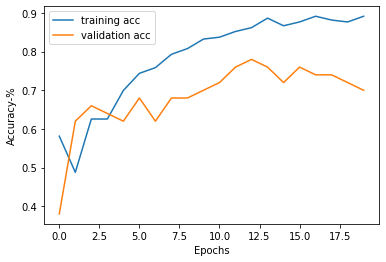

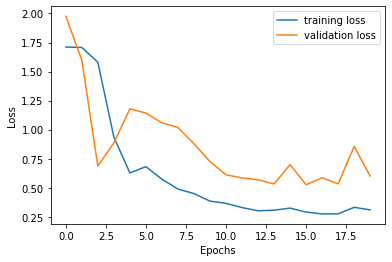

In [ ]:
plot_learning_curve(resnet_history)

## Adding Image augmentation...

In [ ]:
resnet_a_history = model_mobilenet.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=20,
        verbose=True)

Epoch 1/20
8/8 [==============================] - 4s 514ms/step - loss: 0.0269 - accuracy: 0.9881 - val_loss: 0.0315 - val_accuracy: 0.9800
Epoch 2/20
8/8 [==============================] - 4s 452ms/step - loss: 0.0559 - accuracy: 0.9881 - val_loss: 8.8112e-04 - val_accuracy: 1.0000
Epoch 3/20
8/8 [==============================] - 5s 629ms/step - loss: 0.0438 - accuracy: 0.9881 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 4/20
8/8 [==============================] - 5s 594ms/step - loss: 0.0335 - accuracy: 0.9842 - val_loss: 0.0078 - val_accuracy: 1.0000
Epoch 5/20
8/8 [==============================] - 4s 465ms/step - loss: 0.0368 - accuracy: 0.9842 - val_loss: 0.0282 - val_accuracy: 0.9800
Epoch 6/20
8/8 [==============================] - 4s 537ms/step - loss: 0.0188 - accuracy: 0.9881 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 7/20
8/8 [==============================] - 7s 868ms/step - loss: 0.0215 - accuracy: 0.9921 - val_loss: 0.0453 - val_accuracy: 0.9800
Epoch 8/20
8/8 [

In [ ]:
model_evaluation(model_mobilenet,aug_train_ds)

----------------------------------
----------------------------------
         Train       Val
Loss  0.029543  0.000301
Acc   0.988142  1.000000
----------------------------------
----------------------------------
Auc_roc Score :
 1.0
----------------------------------
----------------------------------
Confusion_Matrix:
 [[19  0]
 [ 0 31]]
----------------------------------
----------------------------------

Classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        31

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

----------------------------------
----------------------------------


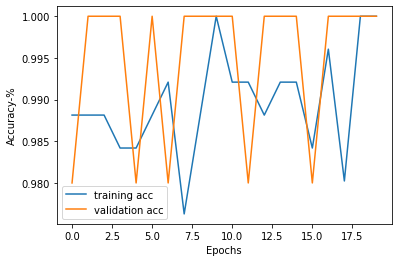

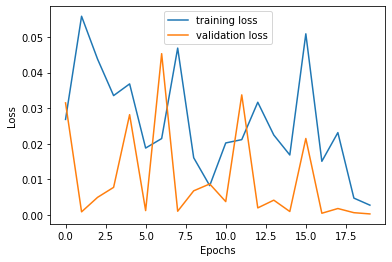

In [ ]:
plot_learning_curve(resnet_a_history)

## VGG16

In [ ]:
vgg = VGG16(input_shape= (height,width,channel), weights='imagenet', include_top=False)

for layer in vgg.layers:
  layer.trainable = False

vgg16_model = Sequential()
vgg16_model.add(vgg)
vgg16_model.add(Flatten())
vgg16_model.add(Dense(1,activation='sigmoid'))
vgg16_model.summary()

vgg16_model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_5 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
vgg16_history = vgg16_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        verbose=True)

Epoch 1/20
4/4 [==============================] - 2s 468ms/step - loss: 0.7311 - accuracy: 0.5665 - val_loss: 0.6011 - val_accuracy: 0.7000
Epoch 2/20
4/4 [==============================] - 2s 543ms/step - loss: 0.4248 - accuracy: 0.8128 - val_loss: 0.4909 - val_accuracy: 0.7800
Epoch 3/20
4/4 [==============================] - 2s 516ms/step - loss: 0.4251 - accuracy: 0.8030 - val_loss: 0.6054 - val_accuracy: 0.7800
Epoch 4/20
4/4 [==============================] - 2s 637ms/step - loss: 0.3086 - accuracy: 0.8522 - val_loss: 0.4716 - val_accuracy: 0.7800
Epoch 5/20
4/4 [==============================] - 2s 469ms/step - loss: 0.3217 - accuracy: 0.8818 - val_loss: 0.4687 - val_accuracy: 0.7600
Epoch 6/20
4/4 [==============================] - 2s 708ms/step - loss: 0.2670 - accuracy: 0.8966 - val_loss: 0.4942 - val_accuracy: 0.7800
Epoch 7/20
4/4 [==============================] - 2s 508ms/step - loss: 0.2060 - accuracy: 0.9261 - val_loss: 0.3833 - val_accuracy: 0.8000
Epoch 8/20
4/4 [====

In [ ]:
model_evaluation(vgg16_model,train_ds)

----------------------------------
----------------------------------
         Train       Val
Loss  0.061293  0.335958
Acc   1.000000  0.840000
----------------------------------
----------------------------------
Auc_roc Score :
 0.8098471986417657
----------------------------------
----------------------------------
Confusion_Matrix:
 [[13  6]
 [ 2 29]]
----------------------------------
----------------------------------

Classification_report:
               precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.94      0.83      0.88        35

    accuracy                           0.84        50
   macro avg       0.81      0.85      0.82        50
weighted avg       0.86      0.84      0.84        50

----------------------------------
----------------------------------


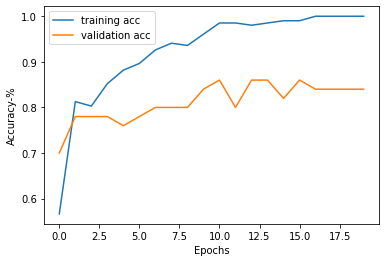

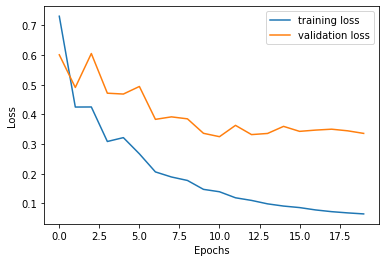

In [ ]:
plot_learning_curve(vgg16_history)

## Adding Image augmentation...

In [ ]:
vgg16_a_history = vgg16_model.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=20,
        #shuffle=True,
        verbose=True)

Epoch 1/20
8/8 [==============================] - 7s 889ms/step - loss: 0.2982 - accuracy: 0.8696 - val_loss: 0.3357 - val_accuracy: 0.8600
Epoch 2/20
8/8 [==============================] - 4s 558ms/step - loss: 0.3314 - accuracy: 0.8498 - val_loss: 0.2701 - val_accuracy: 0.9400
Epoch 3/20
8/8 [==============================] - 5s 575ms/step - loss: 0.2810 - accuracy: 0.8972 - val_loss: 0.2198 - val_accuracy: 0.9200
Epoch 4/20
8/8 [==============================] - 6s 743ms/step - loss: 0.2621 - accuracy: 0.8972 - val_loss: 0.2199 - val_accuracy: 0.9000
Epoch 5/20
8/8 [==============================] - 5s 634ms/step - loss: 0.2636 - accuracy: 0.9012 - val_loss: 0.1709 - val_accuracy: 0.9400
Epoch 6/20
8/8 [==============================] - 5s 517ms/step - loss: 0.2186 - accuracy: 0.9209 - val_loss: 0.1542 - val_accuracy: 0.9200
Epoch 7/20
8/8 [==============================] - 4s 523ms/step - loss: 0.2465 - accuracy: 0.9170 - val_loss: 0.1541 - val_accuracy: 0.9400
Epoch 8/20
8/8 [====

In [ ]:
model_evaluation(vgg16_model,aug_train_ds)

----------------------------------
----------------------------------
         Train       Val
Loss  0.147583  0.068567
Acc   0.956522  0.980000
----------------------------------
----------------------------------
Auc_roc Score :
 0.9838709677419355
----------------------------------
----------------------------------
Confusion_Matrix:
 [[19  0]
 [ 1 30]]
----------------------------------
----------------------------------

Classification_report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.97      1.00      0.98        30

    accuracy                           0.98        50
   macro avg       0.98      0.97      0.98        50
weighted avg       0.98      0.98      0.98        50

----------------------------------
----------------------------------


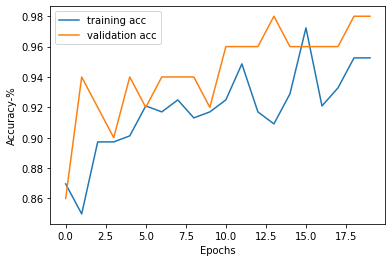

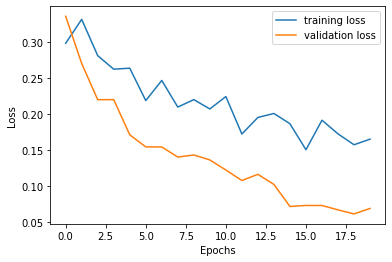

In [ ]:
plot_learning_curve(vgg16_a_history)

## InceptionResNetV2

In [ ]:
inceptionresnet = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(height,width,3),
)

for layer in inceptionresnet.layers:
  layer.trainale = False


inres_model = Sequential()
inres_model.add(inceptionresnet)
inres_model.add(Flatten())
inres_model.add(Dense(32,activation='relu'))
inres_model.add(Dense(1,activation='sigmoid'))
inres_model.summary()

inres_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics = ['accuracy'])

219055592/219055592 [==============================] - 11s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 38400)             0         
                                                                 
 dense_6 (Dense)             (None, 32)                1228832   
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 55,565,601
Trainable params: 55,505,057
Non-trainable params: 60,544
_________________________________________________________________


In [ ]:
inceptionresnet_history = inres_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        verbose=True,)

Epoch 1/20
4/4 [==============================] - 38s 4s/step - loss: 2.9772 - accuracy: 0.6158 - val_loss: 2.5682 - val_accuracy: 0.6200
Epoch 2/20
4/4 [==============================] - 4s 898ms/step - loss: 0.3718 - accuracy: 0.8473 - val_loss: 2.4807 - val_accuracy: 0.7600
Epoch 3/20
4/4 [==============================] - 4s 965ms/step - loss: 0.2694 - accuracy: 0.9507 - val_loss: 1.8929 - val_accuracy: 0.8000
Epoch 4/20
4/4 [==============================] - 4s 928ms/step - loss: 0.1163 - accuracy: 0.9704 - val_loss: 5.8874 - val_accuracy: 0.6800
Epoch 5/20
4/4 [==============================] - 4s 910ms/step - loss: 0.0615 - accuracy: 0.9901 - val_loss: 8.0732 - val_accuracy: 0.6400
Epoch 6/20
4/4 [==============================] - 4s 926ms/step - loss: 0.2197 - accuracy: 0.9212 - val_loss: 262.7476 - val_accuracy: 0.6200
Epoch 7/20
4/4 [==============================] - 4s 913ms/step - loss: 0.2174 - accuracy: 0.9261 - val_loss: 2122.3572 - val_accuracy: 0.6200
Epoch 8/20
4/4 [=

In [ ]:
model_evaluation(inres_model,train_ds)

----------------------------------
----------------------------------
          Train        Val
Loss  42.403408  64.962814
Acc    0.615764   0.620000
----------------------------------
----------------------------------
Auc_roc Score :
 0.5
----------------------------------
----------------------------------
Confusion_Matrix:
 [[ 0 19]
 [ 0 31]]
----------------------------------
----------------------------------

Classification_report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.62      0.77        50

    accuracy                           0.62        50
   macro avg       0.50      0.31      0.38        50
weighted avg       1.00      0.62      0.77        50

----------------------------------
----------------------------------


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


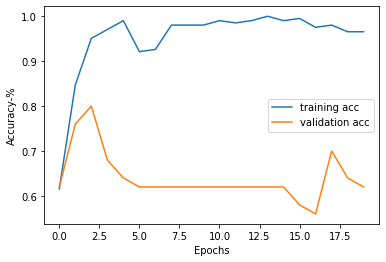

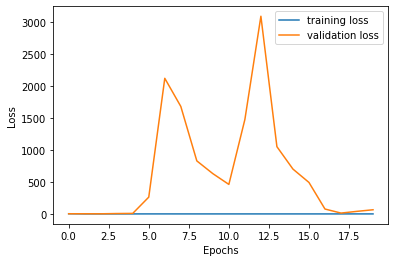

In [ ]:
plot_learning_curve(inceptionresnet_history)

# Adding Image augmentation...

In [ ]:
inceptionresnet_a_history = inres_model.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=20,
        verbose=True)

Epoch 1/20
8/8 [==============================] - 10s 953ms/step - loss: 0.3839 - accuracy: 0.8696 - val_loss: 8.0477 - val_accuracy: 0.6800
Epoch 2/20
8/8 [==============================] - 7s 794ms/step - loss: 0.3576 - accuracy: 0.8814 - val_loss: 60.9305 - val_accuracy: 0.5200
Epoch 3/20
8/8 [==============================] - 7s 827ms/step - loss: 0.2606 - accuracy: 0.8893 - val_loss: 493.3910 - val_accuracy: 0.6000
Epoch 4/20
8/8 [==============================] - 6s 678ms/step - loss: 0.2726 - accuracy: 0.9209 - val_loss: 115.2860 - val_accuracy: 0.6000
Epoch 5/20
8/8 [==============================] - 6s 697ms/step - loss: 0.1641 - accuracy: 0.9328 - val_loss: 25.8301 - val_accuracy: 0.6400
Epoch 6/20
8/8 [==============================] - 6s 673ms/step - loss: 0.1125 - accuracy: 0.9565 - val_loss: 0.3608 - val_accuracy: 0.8600
Epoch 7/20
8/8 [==============================] - 6s 669ms/step - loss: 0.2000 - accuracy: 0.9289 - val_loss: 165.3059 - val_accuracy: 0.6200
Epoch 8/20


In [ ]:
model_evaluation(inres_model,aug_train_ds)

----------------------------------
----------------------------------
         Train       Val
Loss  0.839135  0.569417
Acc   0.877470  0.940000
----------------------------------
----------------------------------
Auc_roc Score :
 0.9210526315789473
----------------------------------
----------------------------------
Confusion_Matrix:
 [[16  3]
 [ 0 31]]
----------------------------------
----------------------------------

Classification_report:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91        16
           1       1.00      0.91      0.95        34

    accuracy                           0.94        50
   macro avg       0.92      0.96      0.93        50
weighted avg       0.95      0.94      0.94        50

----------------------------------
----------------------------------


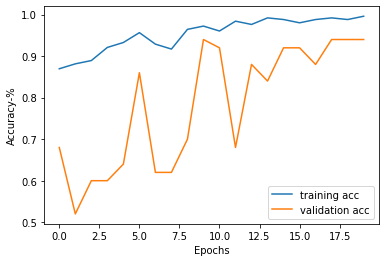

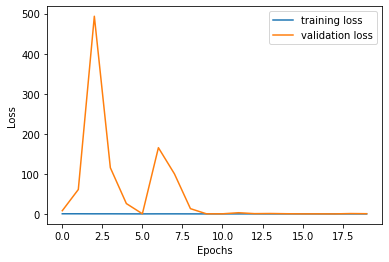

In [ ]:
plot_learning_curve(inceptionresnet_a_history)

## Custom CNN

In [ ]:
cnn_model = Sequential()

cnn_model.add(layers.Conv2D(64,(2,2),activation='relu',strides=2 ,input_shape=(height,width,channel)))
cnn_model.add(layers.Conv2D(128,(2,2),activation='relu',strides=2))
cnn_model.add(layers.MaxPooling2D())

cnn_model.add(layers.Conv2D(32,(2,2),activation='relu',strides=1))
cnn_model.add(layers.Conv2D(64,(2,2),activation='relu',strides=1))
cnn_model.add(layers.MaxPooling2D())
cnn_model.add(layers.Flatten())

cnn_model.add(layers.Dense(128,activation='relu'))
cnn_model.add(layers.Dropout(0.2))
cnn_model.add(layers.Dense(1,'sigmoid'))

cnn_model.summary()

cnn_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_297 (Conv2D)         (None, 112, 112, 64)      832       
                                                                 
 conv2d_298 (Conv2D)         (None, 56, 56, 128)       32896     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 28, 28, 128)      0         
 2D)                                                             
                                                                 
 conv2d_299 (Conv2D)         (None, 27, 27, 32)        16416     
                                                                 
 conv2d_300 (Conv2D)         (None, 26, 26, 64)        8256      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                  

In [ ]:
cnn_history = cnn_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        verbose=True)

Epoch 1/20
4/4 [==============================] - 2s 424ms/step - loss: 0.6778 - accuracy: 0.6207 - val_loss: 0.5925 - val_accuracy: 0.6200
Epoch 2/20
4/4 [==============================] - 1s 257ms/step - loss: 0.5602 - accuracy: 0.7044 - val_loss: 0.5318 - val_accuracy: 0.7400
Epoch 3/20
4/4 [==============================] - 1s 260ms/step - loss: 0.5496 - accuracy: 0.7635 - val_loss: 0.5459 - val_accuracy: 0.7600
Epoch 4/20
4/4 [==============================] - 1s 216ms/step - loss: 0.4876 - accuracy: 0.7537 - val_loss: 0.5355 - val_accuracy: 0.7200
Epoch 5/20
4/4 [==============================] - 1s 211ms/step - loss: 0.4726 - accuracy: 0.7833 - val_loss: 0.5483 - val_accuracy: 0.7600
Epoch 6/20
4/4 [==============================] - 1s 272ms/step - loss: 0.4520 - accuracy: 0.8177 - val_loss: 0.5393 - val_accuracy: 0.7400
Epoch 7/20
4/4 [==============================] - 1s 202ms/step - loss: 0.4269 - accuracy: 0.8374 - val_loss: 0.5497 - val_accuracy: 0.7800
Epoch 8/20
4/4 [====

In [ ]:
model_evaluation(cnn_model,train_ds)

----------------------------------
----------------------------------
         Train       Val
Loss  0.076565  0.571772
Acc   0.970443  0.820000
----------------------------------
----------------------------------
Auc_roc Score :
 0.7835314091680815
----------------------------------
----------------------------------
Confusion_Matrix:
 [[12  7]
 [ 2 29]]
----------------------------------
----------------------------------

Classification_report:
               precision    recall  f1-score   support

           0       0.63      0.86      0.73        14
           1       0.94      0.81      0.87        36

    accuracy                           0.82        50
   macro avg       0.78      0.83      0.80        50
weighted avg       0.85      0.82      0.83        50

----------------------------------
----------------------------------


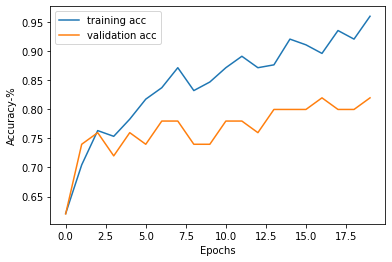

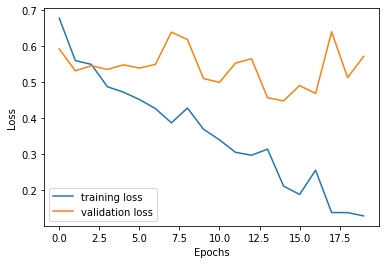

In [ ]:
plot_learning_curve(cnn_history)

## Adding Image augmentation...

In [ ]:
cnn_a_history = cnn_model.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=20,
        verbose=True)

Epoch 1/20
8/8 [==============================] - 4s 455ms/step - loss: 0.6596 - accuracy: 0.7075 - val_loss: 0.4657 - val_accuracy: 0.8000
Epoch 2/20
8/8 [==============================] - 4s 450ms/step - loss: 0.5738 - accuracy: 0.7273 - val_loss: 0.4974 - val_accuracy: 0.8000
Epoch 3/20
8/8 [==============================] - 4s 560ms/step - loss: 0.5590 - accuracy: 0.7549 - val_loss: 0.4528 - val_accuracy: 0.7800
Epoch 4/20
8/8 [==============================] - 3s 443ms/step - loss: 0.5040 - accuracy: 0.8103 - val_loss: 0.5971 - val_accuracy: 0.7800
Epoch 5/20
8/8 [==============================] - 4s 441ms/step - loss: 0.5336 - accuracy: 0.7431 - val_loss: 0.5027 - val_accuracy: 0.7800
Epoch 6/20
8/8 [==============================] - 4s 546ms/step - loss: 0.4743 - accuracy: 0.7787 - val_loss: 0.4773 - val_accuracy: 0.8200
Epoch 7/20
8/8 [==============================] - 4s 436ms/step - loss: 0.5210 - accuracy: 0.7312 - val_loss: 0.5649 - val_accuracy: 0.7800
Epoch 8/20
8/8 [====

In [ ]:
model_evaluation(cnn_model,aug_train_ds)

----------------------------------
----------------------------------
         Train      Val
Loss  0.476806  0.41376
Acc   0.762846  0.86000
----------------------------------
----------------------------------
Auc_roc Score :
 0.8463497453310697
----------------------------------
----------------------------------
Confusion_Matrix:
 [[15  4]
 [ 3 28]]
----------------------------------
----------------------------------

Classification_report:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81        18
           1       0.90      0.88      0.89        32

    accuracy                           0.86        50
   macro avg       0.85      0.85      0.85        50
weighted avg       0.86      0.86      0.86        50

----------------------------------
----------------------------------


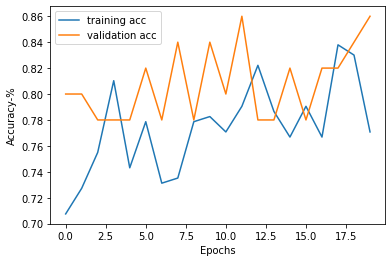

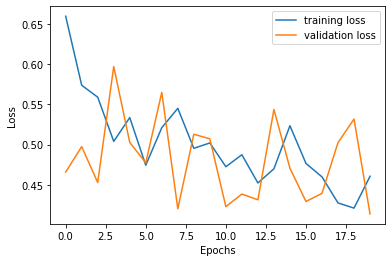

In [ ]:
plot_learning_curve(cnn_a_history)

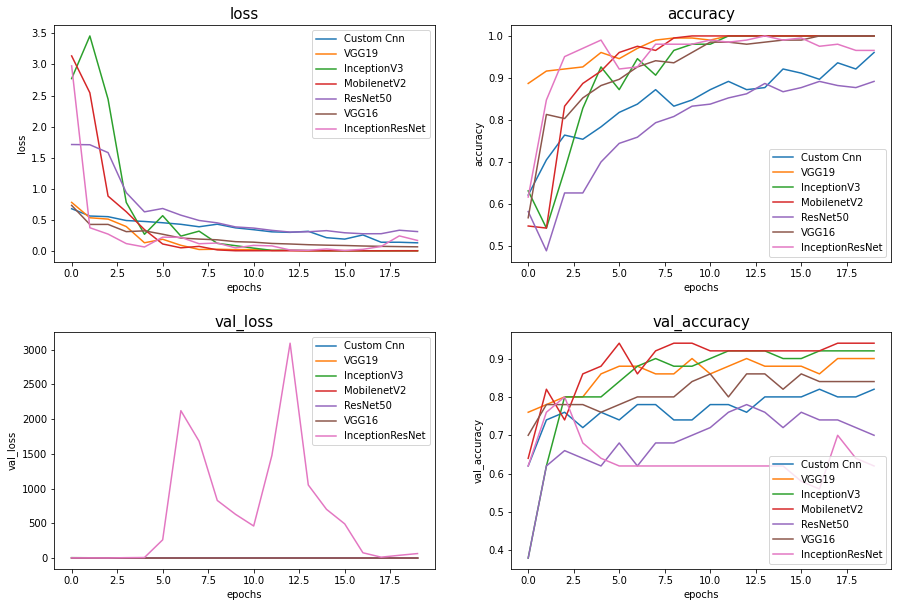

In [ ]:
model_hist = [cnn_history,vgg19_history,inceptionv3_history,mobilenet_history,resnet_history,vgg16_history,inceptionresnet_history]
names = ['Custom Cnn', 'VGG19','InceptionV3','MobilenetV2','ResNet50','VGG16','InceptionResNet']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.3)
for metric in model_hist[0].history:
    index = list(model_hist[0].history).index(metric)
    ax = axes.flatten()[index]
    name_index = 0
    for history in model_hist:
        ax.plot(history.history[metric], label=names[name_index])
        name_index += 1
    ax.set_title(metric, size=15)
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.legend()
plt.show()

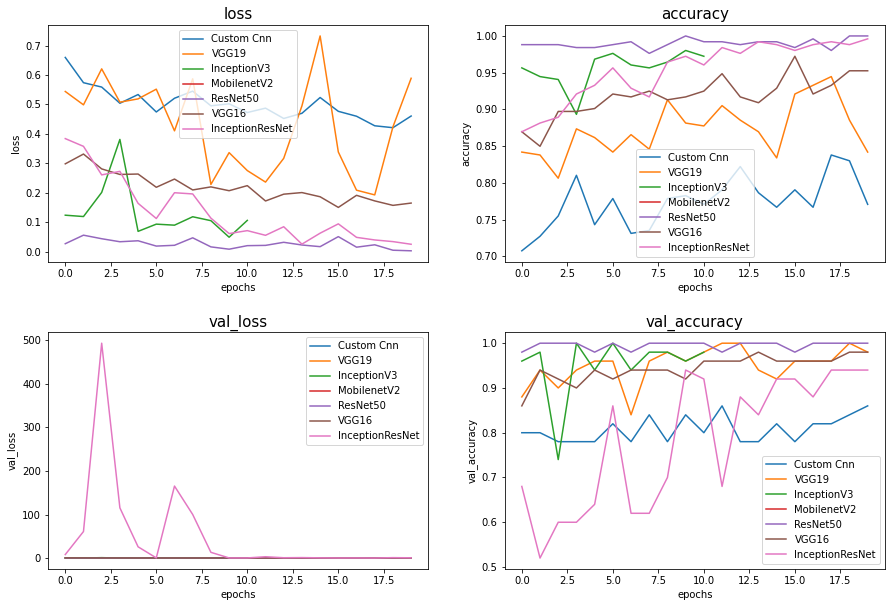

In [ ]:
model_hist = [cnn_a_history,vgg19_a_history,inceptionv3_a_history,mobilenet_a_history,resnet_a_history,vgg16_a_history,inceptionresnet_a_history]
names = ['Custom Cnn', 'VGG19','InceptionV3','MobilenetV2','ResNet50','VGG16','InceptionResNet']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.3)
for metric in model_hist[0].history:
    index = list(model_hist[0].history).index(metric)
    ax = axes.flatten()[index]
    name_index = 0
    for history in model_hist:
        ax.plot(history.history[metric], label=names[name_index])
        name_index += 1
    ax.set_title(metric, size=15)
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.legend()
plt.show()